copy from https://github.com/yashk2810/Image-Captioning

In [1]:
import glob
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
from pprint import pprint
from keras.preprocessing import sequence
from keras.utils import plot_model
from keras.models import Model
from keras.layers import *
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))
%matplotlib inline

Using TensorFlow backend.


In [2]:
token_path = '/home/yzhao/data/ImageCaption/Flickr8k_text/Flickr8k.token.txt'
captions = open(token_path, 'r').read().strip().split('\n')
d = dict()
for i, row in enumerate(captions):
    row = row.split('\t')
    row[0] = row[0][:len(row[0])-2]
    if row[0] in d:
        d[row[0]].append(row[1])
    else:
        d[row[0]] = [row[1]]

In [3]:
print(len(d))
for k, v in d.items():
    print(k)
    pprint(v)
    break

8092
1000268201_693b08cb0e.jpg
['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']


In [4]:
img_path = '/home/yzhao/data/ImageCaption/Flicker8k_Dataset/'
# Contains all the images
images = glob.glob(img_path+'*.jpg')
images[:5]

['/home/yzhao/data/ImageCaption/Flicker8k_Dataset/3461583471_2b8b6b4d73.jpg',
 '/home/yzhao/data/ImageCaption/Flicker8k_Dataset/3439982121_0afc6d5973.jpg',
 '/home/yzhao/data/ImageCaption/Flicker8k_Dataset/1034276567_49bb87c51c.jpg',
 '/home/yzhao/data/ImageCaption/Flicker8k_Dataset/2635905544_dbc65d0622.jpg',
 '/home/yzhao/data/ImageCaption/Flicker8k_Dataset/382151094_c7376cf22b.jpg']

In [5]:
train_images_file = '/home/yzhao/data/ImageCaption/Flickr8k_text/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

def split_data(data):
    temp = []
    split_d = dict()
    for img in images:
        img_name = os.path.split(img)[1]
        if img_name in data:
            temp.append(img)
        if img_name in data:
            split_d[img] = d[img_name]
    return temp, split_d
    
train_images, train_d = split_data(train_images)
print('train:', len(train_images))

val_images_file = '/home/yzhao/data/ImageCaption/Flickr8k_text/Flickr_8k.devImages.txt'
val_images = set(open(val_images_file, 'r').read().strip().split('\n'))
val_images, val_d = split_data(val_images)
print('val:', len(val_images))

test_images_file = '/home/yzhao/data/ImageCaption/Flickr8k_text/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_images, test_d = split_data(test_images)
print('test:', len(test_images))

train: 6000
val: 1000
test: 1000


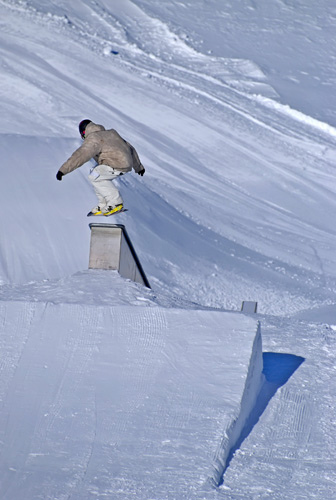

In [6]:
Image.open(train_images[0])

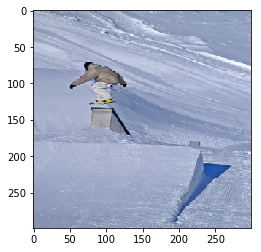

In [7]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    return x

plt.imshow(np.squeeze(preprocess(train_images[0])))

In [8]:
model = InceptionV3(weights='imagenet', include_top=False, pooling='max')  # we remove the last linear layer, but reserved the max pooling.
model.predict(preprocess(train_images[0])).shape

(1, 2048)

In [9]:
def extract_features(images):
    features = {}
    for img in tqdm(images):
        features[os.path.split(img)[1]] = model.predict(preprocess(img)).reshape(-1)
    with open('features.pkl', 'wb') as f:
        pickle.dump(features, f)

In [10]:
if not os.path.exists('features.pkl'):
    extract_features(images)

In [11]:
features = np.load('features.pkl')
features['3556792157_d09d42bef7.jpg'].shape

(2048,)

In [12]:
words = []
max_len = 0
samples_per_epoch = 0
for k, v in train_d.items():
    for s in v:
        if len(s.split()) > max_len:
            max_len = len(s.split())
        samples_per_epoch += len(s.split()) - 1
        words.extend(s.split())
words = ['<pad>', '<start>', '<end>'] + list(set(words))
vocab_size = len(words)
print('vocab_size:', len(words), 'max length:', max_len, 'samples_per_epoch:', samples_per_epoch)
word2id = {w:i for i,w in enumerate(words)}
if not os.path.exists('word2id.pkl'):
    pickle.dump(word2id, open('word2id.pkl', 'wb'))
else:
    word2id = np.load('word2id.pkl')
if not os.path.exists('words.pkl'):
    pickle.dump(words, open('words.pkl', 'wb'))
else:
    words = np.load('words.pkl')

vocab_size: 8257 max length: 38 samples_per_epoch: 323454


In [13]:
with open('flickr8k_training_dataset.csv', 'w') as f:
    f.write("image_id\tcaptions\n")
    for key, val in train_d.items():
        for i in val:
            f.write(os.path.split(key)[1] + "\t" + "<start> " + i +" <end>" + "\n")

In [14]:
df = pd.read_csv('flickr8k_training_dataset.csv', delimiter='\t')
len(df)

30000

In [15]:
def data_generator(batch_size):
    partial_caps = []
    next_words = []
    images = []

    df = pd.read_csv('flickr8k_training_dataset.csv', delimiter='\t')
    df = df.sample(frac=1)
    iter = df.iterrows()
    caps = []
    imgs = []
    for i in range(df.shape[0]):
        x = next(iter)
        caps.append(x[1][1])
        imgs.append(x[1][0])
    
    count = 0
    while True:
        for j, text in enumerate(caps):
            current_image = features[imgs[j]]
            for i in range(len(text.split())-1):
                count+=1

                partial = [word2id[txt] for txt in text.split()[:i+1]]
                partial_caps.append(partial)

                n = np.zeros(vocab_size)
                # Setting the next word to 1 in the one-hot encoded matrix
                n[word2id[text.split()[i+1]]] = 1
                next_words.append(n)

                images.append(current_image)

                if count>=batch_size:
                    next_words = np.asarray(next_words)
                    images = np.asarray(images)
                    partial_caps = sequence.pad_sequences(partial_caps, maxlen=max_len, padding='post')
                    yield [[images, partial_caps], next_words]
                    partial_caps = []
                    next_words = []
                    images = []
                    count = 0

In [16]:
for [[images, partial_caps], next_words] in data_generator(1):
    print(images.shape)
    break

(1, 2048)


In [17]:
embedding_size=200
batch_size = 256

In [18]:
inputs1 = Input(shape=(2048,))
x1 = Dense(embedding_size, activation='relu')(inputs1)
x1 = RepeatVector(max_len)(x1)

inputs2 = Input(shape=(max_len,))
x2 = Embedding(vocab_size + 1, embedding_size, input_length=max_len, mask_zero=True)(inputs2)
x2 = LSTM(256, return_sequences=True)(x2)
x2 = TimeDistributed(Dense(200, activation='relu'))(x2)

x3 = Concatenate()([x1, x2])
x3 = LSTM(256)(x3)
outputs = Dense(vocab_size, activation='softmax')(x3)

model = Model([inputs1, inputs2], outputs)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()
plot_model(model, show_shapes=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 38)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 2048)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 38, 200)       1651600     input_3[0][0]                    
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 200)           409800      input_2[0][0]                    
___________________________________________________________________________________________

In [19]:
if not os.path.exists('InceptionV3.h5'):
    model.fit_generator(data_generator(batch_size=batch_size), steps_per_epoch=samples_per_epoch/batch_size, epochs=3)
    model.save_weights('InceptionV3.h5')
else:
    model.load_weights('InceptionV3.h5')

In [20]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word2id[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        feature = features[os.path.split(image)[1]]
        preds = model.predict([np.reshape(feature, (1, -1)), np.array(par_caps)])
        word_pred = words[np.argmax(preds[0])]
        start_word.append(word_pred)
        if word_pred == "<end>" or len(start_word) > max_len:
            break
    return ' '.join(start_word[1:-1])

In [21]:
def beam_search_predictions(image, beam_index = 5):
    start = [word2id["<start>"]]
    
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_len, padding='post')
            feature = features[os.path.split(image)[1]]
            preds = model.predict([np.reshape(feature, (1, -1)), np.array(par_caps)])
            
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda x: x[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [words[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

greedy: A man in a red shirt is riding a trick on a skateboard .
beam search(k=3): A man in a blue shirt is riding a trick on a skateboard .
beam search(k=5): A man in a blue shirt is riding a trick on a skateboard .
beam search(k=7): A little boy in a red shirt is sitting on a swing .


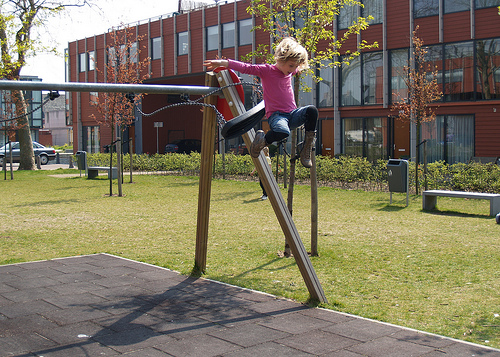

In [22]:
idx = np.random.randint(len(test_images))
print('greedy:', predict_captions(test_images[idx]))
print('beam search(k=3):', beam_search_predictions(test_images[idx], beam_index=3))
print('beam search(k=5):',beam_search_predictions(test_images[idx], beam_index=5))
print('beam search(k=7):',beam_search_predictions(test_images[idx], beam_index=7))
Image.open(test_images[idx])